# Combining Grounding DINO with Segment Anything (SAM) for text-based mask generation

This is based on the popular [Grounded Segment Anything](https://github.com/IDEA-Research/Grounded-Segment-Anything) project.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/grounded_sam.png"
alt="drawing" width="900"/>

<small> Grounded SAM overview. Taken from the <a href="https://github.com/IDEA-Research/Grounded-Segment-Anything">original repository</a>. </small>

## Set-up environment

In [1]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [3]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

## Result Utils

In [4]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

## Plot Utils

In [5]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [6]:
def random_named_css_colors(num_colors: int) -> List[str]:
    """
    Returns a list of randomly selected named CSS colors.

    Args:
    - num_colors (int): Number of random colors to generate.

    Returns:
    - list: List of randomly selected named CSS colors.
    """
    # List of named CSS colors
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    # If class_colors is not provided, generate random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]


    fig = px.imshow(image)

    # Add bounding boxes
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        polygon = mask_to_polygon(mask)

        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode='lines',
            line=dict(color=class_colors[idx], width=2),
            fill='toself',
            name=f"{label}: {score:.2f}"
        ))

        xmin, ymin, xmax, ymax = box.xyxy
        shape = [
            dict(
                type="rect",
                xref="x", yref="y",
                x0=xmin, y0=ymin,
                x1=xmax, y1=ymax,
                line=dict(color=class_colors[idx])
            )
        ]
        annotation = [
            dict(
                x=(xmin+xmax) // 2, y=(ymin+ymax) // 2,
                xref="x", yref="y",
                text=f"{label}: {score:.2f}",
            )
        ]

        shapes.append(shape)
        annotations.append(annotation)

    # Update layout
    button_shapes = [dict(label="None",method="relayout",args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}",method="relayout",args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        # margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show plot
    fig.show()


## Utils

In [7]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

## Grounded Segment Anything (SAM)

The approach:
1. use Grounding DINO to detect a given set of texts ('players' in this case, so both players from Real Madrid and Manchester United) in the image. The output is a set of bounding boxes.
2. prompt Segment Anything (SAM) with the bounding boxes, for which the model will output segmentation masks.

In [8]:
def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections

### Inference
(Change images paths )

In [9]:
image_url = "/content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (74).jpg"
mask_url ="/content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (74).jpg___fuse.png"
labels = ["players from Real Madrid and Manchester United"]
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

In [10]:
# Function to process a single image
def process_image(image_file, labels, threshold):
  image_array, detections = grounded_segmentation(
      image=str(image_file),
      labels=labels,
      threshold=threshold,
      polygon_refinement=True,
      detector_id=detector_id,
      segmenter_id=segmenter_id
  )
  return image_array, detections

In [11]:
image_array, detections = process_image(image_url, labels, threshold)
print("Image_array: ", image_array.shape)
print("Detections: ", detections)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Device set to use cuda


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Image_array:  (1080, 1920, 3)
Detections:  [DetectionResult(score=0.8252487182617188, label='players from Real Madrid and Manchester United.', box=BoundingBox(xmin=501, ymin=326, xmax=1070, ymax=1075), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), DetectionResult(score=0.777178168296814, label='players from Real Madrid and Manchester United.', box=BoundingBox(xmin=170, ymin=399, xmax=627, ymax=1076), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), DetectionResult(score=0.7737112045288086, label='players from Real Madrid and Manchester United.', box=BoundingBox(xmin=1220, ymin=271, xmax=1596, ymax=1076), mask=array([[0, 0, 0, ..., 0, 0, 

In [12]:
ground_truth_mask = cv2.imread(str(mask_url), cv2.IMREAD_GRAYSCALE)
ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)

In [13]:
def calculate_iou(detection_mask, ground_truth_mask):
    intersection = np.logical_and(detection_mask, ground_truth_mask)
    union = np.logical_or(detection_mask, ground_truth_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [14]:
def calculate_pixel_accuracy(detection_mask, ground_truth_mask):
  return np.mean(detection_mask == ground_truth_mask)

In [15]:
def calculate_mean_absolute_error(detection_mask, ground_truth_mask):
  return np.mean(np.abs(detection_mask.astype(float) - ground_truth_mask.astype(float)))

## trial - evaluation functions

In [16]:
import numpy as np
from sklearn.metrics import f1_score
from typing import Dict, Any

def evaluate_detection(detection_mask: np.ndarray, ground_truth_mask: np.ndarray) -> Dict[str, float]:
  # Make masks binary
  detection_mask = detection_mask.astype(bool)
  ground_truth_mask = ground_truth_mask.astype(bool)

  # Intersection over Union - IoU
  iou = calculate_iou(detection_mask, ground_truth_mask)

  # Pixel Accuracy
  pixel_accuracy = calculate_pixel_accuracy(detection_mask, ground_truth_mask)

  # Mean Absolute Error
  mae = calculate_mean_absolute_error(detection_mask, ground_truth_mask)

  # F1 score
  f1 = f1_score(ground_truth_mask.flatten(), detection_mask.flatten())

  return {
      'iou': iou,
      'pixel_accuracy': pixel_accuracy,
      'mae': mae,
      'f1_score': f1
  }

In [17]:
evaluate_detection(detections[0].mask, ground_truth_mask)

{'iou': 0.06551552854938271,
 'pixel_accuracy': 0.06551552854938271,
 'mae': 0.9344844714506173,
 'f1_score': 0.12297432894023996}

Let's visualize the results:

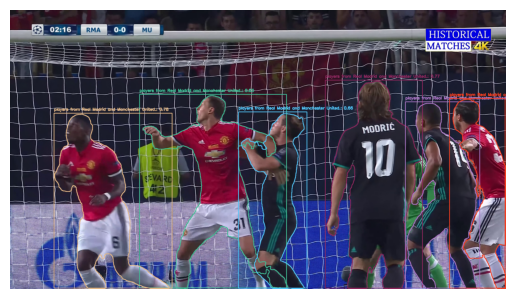

In [18]:
plot_detections(image_array, detections)

In [19]:
plot_detections_plotly(image_array, detections)

## Iterating through dataset and getting name

In [20]:
import os
from pathlib import Path

In [21]:
root_dir = Path("/content/drive/MyDrive/DTU/MLOPs/archive/images")

In [22]:
# See if root directory exists
print(f"Root directory exists: {root_dir.exists()}")

Root directory exists: True


In [23]:
import os
from pathlib import Path
import cv2
import numpy as np

def process_football_dataset(root_dir):
    root_dir = Path(root_dir)

    # Verify root directory exists
    #print(f"Root directory exists: {root_dir.exists()}")

    # Get all original images (files without ___fuse.png or ___save.png)
    image_files = [f for f in root_dir.glob("Frame*.jpg") if not str(f).endswith(("___fuse.png", "___save.png"))]
    print(f"Number of images found: {len(image_files)}")

    all_results = []

    for jpg_file in image_files:
        print(f"Processing {jpg_file.name}")

        # Construct paths for corresponding mask files
        fuse_mask = root_dir / f"{jpg_file.name}___fuse.png"
        save_mask = root_dir / f"{jpg_file.name}___save.png"

        # Verify mask files exist
        if fuse_mask.exists() and save_mask.exists():
            print(f"Fuse mask exists: {fuse_mask}")
            print(f"Save mask exists: {save_mask}")

            # Read image and masks
            image = cv2.imread(str(jpg_file))

            # You can choose which mask to use (fuse or save) based on your needs
            # Here we're using the fuse mask as an example
            ground_truth_mask = cv2.imread(str(fuse_mask), cv2.IMREAD_GRAYSCALE)
            ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)

            # Apply the detection method - no plots
            image_array, detections = process_image(str(jpg_file), labels, threshold)

            # Resize ground truth mask to match the shape of the detection mask
            if len(detections) > 0:  # Check if any detections were made
                ground_truth_mask = cv2.resize(
                    ground_truth_mask,
                    (detections[0].mask.shape[1], detections[0].mask.shape[0]),
                    interpolation=cv2.INTER_NEAREST
                )

                # Evaluate detection
                result = evaluate_detection(detections[0].mask, ground_truth_mask)
                result['image'] = jpg_file.name

                all_results.append(result)

                print(f"Processed {jpg_file.name}; Results: {result}")
            else:
                print(f"No detections found for {jpg_file.name}")
        else:
            print(f"Mask files not found for {jpg_file.name}")

    return all_results

# Usage
#root_dir = Path("/path/to/your/football/dataset/images")
results = process_football_dataset(root_dir)

Number of images found: 100
Processing Frame 1  (15).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (15).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (15).jpg___save.png


Device set to use cuda


Processed Frame 1  (15).jpg; Results: {'iou': 0.10348770422825243, 'pixel_accuracy': 0.10348813657407407, 'mae': 0.8965118634259259, 'f1_score': 0.18756476185772952, 'image': 'Frame 1  (15).jpg'}
Processing Frame 1  (20).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (20).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (20).jpg___save.png


Device set to use cuda


Processed Frame 1  (20).jpg; Results: {'iou': 0.026890689009082716, 'pixel_accuracy': 0.027196662808641976, 'mae': 0.972803337191358, 'f1_score': 0.05237303112570119, 'image': 'Frame 1  (20).jpg'}
Processing Frame 1  (19).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (19).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (19).jpg___save.png


Device set to use cuda


Processed Frame 1  (19).jpg; Results: {'iou': 0.027485545662396634, 'pixel_accuracy': 0.027486014660493826, 'mae': 0.9725139853395062, 'f1_score': 0.053500598190269096, 'image': 'Frame 1  (19).jpg'}
Processing Frame 1  (17).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (17).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (17).jpg___save.png


Device set to use cuda


Processed Frame 1  (17).jpg; Results: {'iou': 0.017063569185749028, 'pixel_accuracy': 0.017064043209876544, 'mae': 0.9829359567901235, 'f1_score': 0.0335545775165459, 'image': 'Frame 1  (17).jpg'}
Processing Frame 1  (12).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (12).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (12).jpg___save.png


Device set to use cuda


Processed Frame 1  (12).jpg; Results: {'iou': 0.0961203202740742, 'pixel_accuracy': 0.09612075617283951, 'mae': 0.9038792438271605, 'f1_score': 0.17538279054992842, 'image': 'Frame 1  (12).jpg'}
Processing Frame 1  (1).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (1).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (1).jpg___save.png


Device set to use cuda


Processed Frame 1  (1).jpg; Results: {'iou': 0.053114390432098764, 'pixel_accuracy': 0.053114390432098764, 'mae': 0.9468856095679012, 'f1_score': 0.10087107519308636, 'image': 'Frame 1  (1).jpg'}
Processing Frame 1  (11).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (11).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (11).jpg___save.png


Device set to use cuda


Processed Frame 1  (11).jpg; Results: {'iou': 0.1124156599226755, 'pixel_accuracy': 0.11241608796296296, 'mae': 0.887583912037037, 'f1_score': 0.2021108906907865, 'image': 'Frame 1  (11).jpg'}
Processing Frame 1  (13).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (13).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (13).jpg___save.png


Device set to use cuda


Processed Frame 1  (13).jpg; Results: {'iou': 0.09880357774092291, 'pixel_accuracy': 0.09880401234567901, 'mae': 0.901195987654321, 'f1_score': 0.17983847111975626, 'image': 'Frame 1  (13).jpg'}
Processing Frame 1  (16).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (16).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (16).jpg___save.png


Device set to use cuda


Processed Frame 1  (16).jpg; Results: {'iou': 0.021435195522374384, 'pixel_accuracy': 0.021435667438271605, 'mae': 0.9785643325617284, 'f1_score': 0.041970740026071186, 'image': 'Frame 1  (16).jpg'}
Processing Frame 1  (10).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (10).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (10).jpg___save.png


Device set to use cuda


Processed Frame 1  (10).jpg; Results: {'iou': 0.04564093636233428, 'pixel_accuracy': 0.045641396604938274, 'mae': 0.9543586033950617, 'f1_score': 0.08729753163856399, 'image': 'Frame 1  (10).jpg'}
Processing Frame 1  (2).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (2).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (2).jpg___save.png


Device set to use cuda


Processed Frame 1  (2).jpg; Results: {'iou': 0.07187114197530864, 'pixel_accuracy': 0.07187114197530864, 'mae': 0.9281288580246914, 'f1_score': 0.134104071209269, 'image': 'Frame 1  (2).jpg'}
Processing Frame 1  (23).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (23).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (23).jpg___save.png


Device set to use cuda


Processed Frame 1  (23).jpg; Results: {'iou': 0.011453034072643746, 'pixel_accuracy': 0.011453510802469136, 'mae': 0.9885464891975309, 'f1_score': 0.022646694778358192, 'image': 'Frame 1  (23).jpg'}
Processing Frame 1  (22).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (22).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (22).jpg___save.png


Device set to use cuda


Processed Frame 1  (22).jpg; Results: {'iou': 0.010445124635959025, 'pixel_accuracy': 0.010445601851851852, 'mae': 0.9895543981481482, 'f1_score': 0.020674303594115855, 'image': 'Frame 1  (22).jpg'}
Processing Frame 1  (14).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (14).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (14).jpg___save.png


Device set to use cuda


Processed Frame 1  (14).jpg; Results: {'iou': 0.05814766589506173, 'pixel_accuracy': 0.05814766589506173, 'mae': 0.9418523341049383, 'f1_score': 0.10990463386010688, 'image': 'Frame 1  (14).jpg'}
Processing Frame 1  (100).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (100).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (100).jpg___save.png


Device set to use cuda


Processed Frame 1  (100).jpg; Results: {'iou': 0.005516013462583653, 'pixel_accuracy': 0.005516493055555556, 'mae': 0.9944835069444444, 'f1_score': 0.010971507939667257, 'image': 'Frame 1  (100).jpg'}
Processing Frame 1  (18).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (18).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (18).jpg___save.png


Device set to use cuda


Processed Frame 1  (18).jpg; Results: {'iou': 0.015106102963977124, 'pixel_accuracy': 0.015106577932098766, 'mae': 0.9848934220679012, 'f1_score': 0.029762608893531974, 'image': 'Frame 1  (18).jpg'}
Processing Frame 1  (21).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (21).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (21).jpg___save.png


Device set to use cuda


Processed Frame 1  (21).jpg; Results: {'iou': 0.013987757517244173, 'pixel_accuracy': 0.013988233024691358, 'mae': 0.9860117669753087, 'f1_score': 0.027589598421766535, 'image': 'Frame 1  (21).jpg'}
Processing Frame 1  (44).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (44).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (44).jpg___save.png


Device set to use cuda


Processed Frame 1  (44).jpg; Results: {'iou': 0.022840065528770593, 'pixel_accuracy': 0.022843364197530865, 'mae': 0.9771566358024691, 'f1_score': 0.04466009163800818, 'image': 'Frame 1  (44).jpg'}
Processing Frame 1  (33).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (33).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (33).jpg___save.png


Device set to use cuda


Processed Frame 1  (33).jpg; Results: {'iou': 0.01527971415881277, 'pixel_accuracy': 0.015280189043209876, 'mae': 0.9847198109567902, 'f1_score': 0.03009951631205876, 'image': 'Frame 1  (33).jpg'}
Processing Frame 1  (28).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (28).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (28).jpg___save.png


Device set to use cuda


Processed Frame 1  (28).jpg; Results: {'iou': 0.021084430315282645, 'pixel_accuracy': 0.021099537037037038, 'mae': 0.978900462962963, 'f1_score': 0.041298113435678095, 'image': 'Frame 1  (28).jpg'}
Processing Frame 1  (27).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (27).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (27).jpg___save.png


Device set to use cuda


Processed Frame 1  (27).jpg; Results: {'iou': 0.08660980257031374, 'pixel_accuracy': 0.08661024305555555, 'mae': 0.9133897569444445, 'f1_score': 0.15941288651260677, 'image': 'Frame 1  (27).jpg'}
Processing Frame 1  (25).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (25).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (25).jpg___save.png


Device set to use cuda


Processed Frame 1  (25).jpg; Results: {'iou': 0.010122224815727186, 'pixel_accuracy': 0.010143229166666667, 'mae': 0.9898567708333333, 'f1_score': 0.02004158421041324, 'image': 'Frame 1  (25).jpg'}
Processing Frame 1  (24).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (24).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (24).jpg___save.png


Device set to use cuda


Processed Frame 1  (24).jpg; Results: {'iou': 0.012163875464831917, 'pixel_accuracy': 0.012164351851851852, 'mae': 0.9878356481481482, 'f1_score': 0.02403538746973302, 'image': 'Frame 1  (24).jpg'}
Processing Frame 1  (3).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (3).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (3).jpg___save.png


Device set to use cuda


Processed Frame 1  (3).jpg; Results: {'iou': 0.07046006944444444, 'pixel_accuracy': 0.07046006944444444, 'mae': 0.9295399305555555, 'f1_score': 0.13164446102321659, 'image': 'Frame 1  (3).jpg'}
Processing Frame 1  (40).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (40).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (40).jpg___save.png


Device set to use cuda


Processed Frame 1  (40).jpg; Results: {'iou': 0.02120563271604938, 'pixel_accuracy': 0.02120563271604938, 'mae': 0.9787943672839506, 'f1_score': 0.041530583139557944, 'image': 'Frame 1  (40).jpg'}
Processing Frame 1  (31).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (31).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (31).jpg___save.png


Device set to use cuda


Processed Frame 1  (31).jpg; Results: {'iou': 0.11029036954589581, 'pixel_accuracy': 0.11029079861111112, 'mae': 0.8897092013888889, 'f1_score': 0.19866941580517197, 'image': 'Frame 1  (31).jpg'}
Processing Frame 1  (42).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (42).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (42).jpg___save.png


Device set to use cuda


Processed Frame 1  (42).jpg; Results: {'iou': 0.009594916661763755, 'pixel_accuracy': 0.009595871913580247, 'mae': 0.9904041280864198, 'f1_score': 0.019007458344757616, 'image': 'Frame 1  (42).jpg'}
Processing Frame 1  (39).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (39).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (39).jpg___save.png


Device set to use cuda


Processed Frame 1  (39).jpg; Results: {'iou': 0.023382545700757814, 'pixel_accuracy': 0.023383487654320988, 'mae': 0.976616512345679, 'f1_score': 0.04569658882494755, 'image': 'Frame 1  (39).jpg'}
Processing Frame 1  (35).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (35).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (35).jpg___save.png


Device set to use cuda


Processed Frame 1  (35).jpg; Results: {'iou': 0.021566850678458083, 'pixel_accuracy': 0.021567322530864196, 'mae': 0.9784326774691358, 'f1_score': 0.042223082442690435, 'image': 'Frame 1  (35).jpg'}
Processing Frame 1  (43).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (43).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (43).jpg___save.png


Device set to use cuda


Processed Frame 1  (43).jpg; Results: {'iou': 0.022879050925925924, 'pixel_accuracy': 0.022879050925925924, 'mae': 0.9771209490740741, 'f1_score': 0.04473461628765484, 'image': 'Frame 1  (43).jpg'}
Processing Frame 1  (26).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (26).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (26).jpg___save.png


Device set to use cuda


Processed Frame 1  (26).jpg; Results: {'iou': 0.09449464433576597, 'pixel_accuracy': 0.09449508101851851, 'mae': 0.9055049189814814, 'f1_score': 0.17267264819393155, 'image': 'Frame 1  (26).jpg'}
Processing Frame 1  (32).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (32).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (32).jpg___save.png


Device set to use cuda


Processed Frame 1  (32).jpg; Results: {'iou': 0.02063561951949244, 'pixel_accuracy': 0.020636091820987655, 'mae': 0.9793639081790123, 'f1_score': 0.04043680060707176, 'image': 'Frame 1  (32).jpg'}
Processing Frame 1  (29).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (29).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (29).jpg___save.png


Device set to use cuda


Processed Frame 1  (29).jpg; Results: {'iou': 0.0626606204960554, 'pixel_accuracy': 0.0626610725308642, 'mae': 0.9373389274691358, 'f1_score': 0.11793157530727941, 'image': 'Frame 1  (29).jpg'}
Processing Frame 1  (41).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (41).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (41).jpg___save.png


Device set to use cuda


Processed Frame 1  (41).jpg; Results: {'iou': 0.0048914954144943165, 'pixel_accuracy': 0.0048919753086419755, 'mae': 0.9951080246913581, 'f1_score': 0.009735370309760037, 'image': 'Frame 1  (41).jpg'}
Processing Frame 1  (38).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (38).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (38).jpg___save.png


Device set to use cuda


Processed Frame 1  (38).jpg; Results: {'iou': 0.08617967417021043, 'pixel_accuracy': 0.08618055555555555, 'mae': 0.9138194444444444, 'f1_score': 0.15868401189894774, 'image': 'Frame 1  (38).jpg'}
Processing Frame 1  (34).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (34).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (34).jpg___save.png


Device set to use cuda


Processed Frame 1  (34).jpg; Results: {'iou': 0.007503861643451796, 'pixel_accuracy': 0.007504340277777778, 'mae': 0.9924956597222222, 'f1_score': 0.014895946167812023, 'image': 'Frame 1  (34).jpg'}
Processing Frame 1  (37).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (37).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (37).jpg___save.png


Device set to use cuda


Processed Frame 1  (37).jpg; Results: {'iou': 0.06777648527218817, 'pixel_accuracy': 0.06782503858024691, 'mae': 0.9321749614197531, 'f1_score': 0.1269488253525478, 'image': 'Frame 1  (37).jpg'}
Processing Frame 1  (30).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (30).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (30).jpg___save.png


Device set to use cuda


Processed Frame 1  (30).jpg; Results: {'iou': 0.013291377314814815, 'pixel_accuracy': 0.013291377314814815, 'mae': 0.9867086226851852, 'f1_score': 0.02623406773683692, 'image': 'Frame 1  (30).jpg'}
Processing Frame 1  (4).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (4).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (4).jpg___save.png


Device set to use cuda


Processed Frame 1  (4).jpg; Results: {'iou': 0.0781298225308642, 'pixel_accuracy': 0.0781298225308642, 'mae': 0.9218701774691358, 'f1_score': 0.1449358340676594, 'image': 'Frame 1  (4).jpg'}
Processing Frame 1  (36).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (36).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (36).jpg___save.png


Device set to use cuda


Processed Frame 1  (36).jpg; Results: {'iou': 0.05504918981481482, 'pixel_accuracy': 0.05504918981481482, 'mae': 0.9449508101851852, 'f1_score': 0.10435378813849845, 'image': 'Frame 1  (36).jpg'}
Processing Frame 1  (45).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (45).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (45).jpg___save.png


Device set to use cuda


Processed Frame 1  (45).jpg; Results: {'iou': 0.019584780092592593, 'pixel_accuracy': 0.019584780092592593, 'mae': 0.9804152199074074, 'f1_score': 0.03841716839047758, 'image': 'Frame 1  (45).jpg'}
Processing Frame 1  (69).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (69).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (69).jpg___save.png


Device set to use cuda


Processed Frame 1  (69).jpg; Results: {'iou': 0.16936640112191412, 'pixel_accuracy': 0.16936680169753088, 'mae': 0.8306331983024692, 'f1_score': 0.2896720838899091, 'image': 'Frame 1  (69).jpg'}
Processing Frame 1  (5).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (5).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (5).jpg___save.png


Device set to use cuda


Processed Frame 1  (5).jpg; Results: {'iou': 0.0733396222047317, 'pixel_accuracy': 0.07338252314814815, 'mae': 0.9266174768518518, 'f1_score': 0.13665688042725158, 'image': 'Frame 1  (5).jpg'}
Processing Frame 1  (65).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (65).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (65).jpg___save.png


Device set to use cuda


Processed Frame 1  (65).jpg; Results: {'iou': 0.030733989197530863, 'pixel_accuracy': 0.030733989197530863, 'mae': 0.9692660108024691, 'f1_score': 0.05963515226942026, 'image': 'Frame 1  (65).jpg'}
Processing Frame 1  (6).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (6).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (6).jpg___save.png


Device set to use cuda


Processed Frame 1  (6).jpg; Results: {'iou': 0.06926842206790124, 'pixel_accuracy': 0.06926842206790124, 'mae': 0.9307315779320988, 'f1_score': 0.12956227012472743, 'image': 'Frame 1  (6).jpg'}
Processing Frame 1  (68).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (68).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (68).jpg___save.png


Device set to use cuda


Processed Frame 1  (68).jpg; Results: {'iou': 0.16017127708877174, 'pixel_accuracy': 0.16017168209876542, 'mae': 0.8398283179012346, 'f1_score': 0.2761166049390414, 'image': 'Frame 1  (68).jpg'}
Processing Frame 1  (56).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (56).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (56).jpg___save.png


Device set to use cuda


Processed Frame 1  (56).jpg; Results: {'iou': 0.01705392411936927, 'pixel_accuracy': 0.01705439814814815, 'mae': 0.9829456018518519, 'f1_score': 0.033535929049456556, 'image': 'Frame 1  (56).jpg'}
Processing Frame 1  (55).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (55).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (55).jpg___save.png


Device set to use cuda


Processed Frame 1  (55).jpg; Results: {'iou': 0.013117766203703704, 'pixel_accuracy': 0.013117766203703704, 'mae': 0.9868822337962962, 'f1_score': 0.025895836873649623, 'image': 'Frame 1  (55).jpg'}
Processing Frame 1  (49).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (49).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (49).jpg___save.png


Device set to use cuda


Processed Frame 1  (49).jpg; Results: {'iou': 0.016785791274011995, 'pixel_accuracy': 0.016786265432098765, 'mae': 0.9832137345679013, 'f1_score': 0.033017360034073136, 'image': 'Frame 1  (49).jpg'}
Processing Frame 1  (67).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (67).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (67).jpg___save.png


Device set to use cuda


Processed Frame 1  (67).jpg; Results: {'iou': 0.03917824074074074, 'pixel_accuracy': 0.03917824074074074, 'mae': 0.9608217592592593, 'f1_score': 0.07540235005847302, 'image': 'Frame 1  (67).jpg'}
Processing Frame 1  (52).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (52).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (52).jpg___save.png


Device set to use cuda


Processed Frame 1  (52).jpg; Results: {'iou': 0.06724681712962963, 'pixel_accuracy': 0.06724681712962963, 'mae': 0.9327531828703703, 'f1_score': 0.12601924137940385, 'image': 'Frame 1  (52).jpg'}
Processing Frame 1  (64).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (64).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (64).jpg___save.png


Device set to use cuda


Processed Frame 1  (64).jpg; Results: {'iou': 0.05174192310085026, 'pixel_accuracy': 0.05174238040123457, 'mae': 0.9482576195987654, 'f1_score': 0.09839281284575892, 'image': 'Frame 1  (64).jpg'}
Processing Frame 1  (51).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (51).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (51).jpg___save.png


Device set to use cuda


Processed Frame 1  (51).jpg; Results: {'iou': 0.02205537329059283, 'pixel_accuracy': 0.022055844907407408, 'mae': 0.9779441550925926, 'f1_score': 0.04315886177396379, 'image': 'Frame 1  (51).jpg'}
Processing Frame 1  (53).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (53).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (53).jpg___save.png


Device set to use cuda


Processed Frame 1  (53).jpg; Results: {'iou': 0.019237084894427516, 'pixel_accuracy': 0.019237557870370372, 'mae': 0.9807624421296296, 'f1_score': 0.03774800815145004, 'image': 'Frame 1  (53).jpg'}
Processing Frame 1  (58).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (58).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (58).jpg___save.png


Device set to use cuda


Processed Frame 1  (58).jpg; Results: {'iou': 0.014695223136199429, 'pixel_accuracy': 0.014695698302469137, 'mae': 0.9853043016975309, 'f1_score': 0.028964802043277057, 'image': 'Frame 1  (58).jpg'}
Processing Frame 1  (59).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (59).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (59).jpg___save.png


Device set to use cuda


Processed Frame 1  (59).jpg; Results: {'iou': 0.017701099537037038, 'pixel_accuracy': 0.017701099537037038, 'mae': 0.982298900462963, 'f1_score': 0.03478644082253513, 'image': 'Frame 1  (59).jpg'}
Processing Frame 1  (63).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (63).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (63).jpg___save.png


Device set to use cuda


Processed Frame 1  (63).jpg; Results: {'iou': 0.04833960262345679, 'pixel_accuracy': 0.04833960262345679, 'mae': 0.9516603973765432, 'f1_score': 0.09222126589988118, 'image': 'Frame 1  (63).jpg'}
Processing Frame 1  (48).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (48).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (48).jpg___save.png


Device set to use cuda


Processed Frame 1  (48).jpg; Results: {'iou': 0.015098869164192305, 'pixel_accuracy': 0.015099344135802469, 'mae': 0.9849006558641975, 'f1_score': 0.02974856858352004, 'image': 'Frame 1  (48).jpg'}
Processing Frame 1  (54).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (54).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (54).jpg___save.png


Device set to use cuda


Processed Frame 1  (54).jpg; Results: {'iou': 0.012544855586832363, 'pixel_accuracy': 0.012545331790123456, 'mae': 0.9874546682098766, 'f1_score': 0.02477886390437852, 'image': 'Frame 1  (54).jpg'}
Processing Frame 1  (57).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (57).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (57).jpg___save.png


Device set to use cuda


Processed Frame 1  (57).jpg; Results: {'iou': 0.012339897926262503, 'pixel_accuracy': 0.012340374228395061, 'mae': 0.9876596257716049, 'f1_score': 0.024378961950507507, 'image': 'Frame 1  (57).jpg'}
Processing Frame 1  (60).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (60).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (60).jpg___save.png


Device set to use cuda


Processed Frame 1  (60).jpg; Results: {'iou': 0.035713252314814814, 'pixel_accuracy': 0.035713252314814814, 'mae': 0.9642867476851852, 'f1_score': 0.06896359052082388, 'image': 'Frame 1  (60).jpg'}
Processing Frame 1  (50).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (50).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (50).jpg___save.png


Device set to use cuda


Processed Frame 1  (50).jpg; Results: {'iou': 0.01983700802324847, 'pixel_accuracy': 0.019837480709876544, 'mae': 0.9801625192901234, 'f1_score': 0.038902310599021245, 'image': 'Frame 1  (50).jpg'}
Processing Frame 1  (61).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (61).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (61).jpg___save.png


Device set to use cuda


Processed Frame 1  (61).jpg; Results: {'iou': 0.03753620518538309, 'pixel_accuracy': 0.03753713348765432, 'mae': 0.9624628665123457, 'f1_score': 0.07235642476433149, 'image': 'Frame 1  (61).jpg'}
Processing Frame 1  (62).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (62).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (62).jpg___save.png


Device set to use cuda


Processed Frame 1  (62).jpg; Results: {'iou': 0.0216010116160296, 'pixel_accuracy': 0.02164158950617284, 'mae': 0.9783584104938272, 'f1_score': 0.04228854781938759, 'image': 'Frame 1  (62).jpg'}
Processing Frame 1  (66).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (66).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (66).jpg___save.png


Device set to use cuda


Processed Frame 1  (66).jpg; Results: {'iou': 0.03891113323208322, 'pixel_accuracy': 0.039913194444444446, 'mae': 0.9600868055555556, 'f1_score': 0.07490752959982157, 'image': 'Frame 1  (66).jpg'}
Processing Frame 1  (46).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (46).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (46).jpg___save.png


Device set to use cuda


Processed Frame 1  (46).jpg; Results: {'iou': 0.019050452859979194, 'pixel_accuracy': 0.019050925925925926, 'mae': 0.9809490740740741, 'f1_score': 0.03738863528594455, 'image': 'Frame 1  (46).jpg'}
Processing Frame 1  (47).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (47).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (47).jpg___save.png


Device set to use cuda


Processed Frame 1  (47).jpg; Results: {'iou': 0.018070987654320986, 'pixel_accuracy': 0.018070987654320986, 'mae': 0.981929012345679, 'f1_score': 0.03550044716617908, 'image': 'Frame 1  (47).jpg'}
Processing Frame 1  (70).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (70).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (70).jpg___save.png


Device set to use cuda


Processed Frame 1  (70).jpg; Results: {'iou': 0.1730869854779058, 'pixel_accuracy': 0.17308738425925926, 'mae': 0.8269126157407407, 'f1_score': 0.29509659150705114, 'image': 'Frame 1  (70).jpg'}
Processing Frame 1  (82).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (82).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (82).jpg___save.png


Device set to use cuda


Processed Frame 1  (82).jpg; Results: {'iou': 0.07614101080246914, 'pixel_accuracy': 0.07614101080246914, 'mae': 0.9238589891975308, 'f1_score': 0.14150749769436152, 'image': 'Frame 1  (82).jpg'}
Processing Frame 1  (74).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (74).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (74).jpg___save.png


Device set to use cuda


Processed Frame 1  (74).jpg; Results: {'iou': 0.06551552854938271, 'pixel_accuracy': 0.06551552854938271, 'mae': 0.9344844714506173, 'f1_score': 0.12297432894023996, 'image': 'Frame 1  (74).jpg'}
Processing Frame 1  (8).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (8).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (8).jpg___save.png


Device set to use cuda


Processed Frame 1  (8).jpg; Results: {'iou': 0.052956846904456706, 'pixel_accuracy': 0.05295958719135802, 'mae': 0.9470404128086419, 'f1_score': 0.10058692729933293, 'image': 'Frame 1  (8).jpg'}
Processing Frame 1  (81).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (81).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (81).jpg___save.png


Device set to use cuda


Processed Frame 1  (81).jpg; Results: {'iou': 0.07920829322587428, 'pixel_accuracy': 0.07921006944444445, 'mae': 0.9207899305555556, 'f1_score': 0.1467896303671126, 'image': 'Frame 1  (81).jpg'}
Processing Frame 1  (77).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (77).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (77).jpg___save.png


Device set to use cuda


Processed Frame 1  (77).jpg; Results: {'iou': 0.06915943287037037, 'pixel_accuracy': 0.06915943287037037, 'mae': 0.9308405671296296, 'f1_score': 0.12937159930338576, 'image': 'Frame 1  (77).jpg'}
Processing Frame 1  (84).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (84).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (84).jpg___save.png


Device set to use cuda


Processed Frame 1  (84).jpg; Results: {'iou': 0.04785445601851852, 'pixel_accuracy': 0.04785445601851852, 'mae': 0.9521455439814814, 'f1_score': 0.09133798256744312, 'image': 'Frame 1  (84).jpg'}
Processing Frame 1  (75).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (75).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (75).jpg___save.png


Device set to use cuda


Processed Frame 1  (75).jpg; Results: {'iou': 0.07312596185055344, 'pixel_accuracy': 0.07318094135802469, 'mae': 0.9268190586419753, 'f1_score': 0.13628588711888265, 'image': 'Frame 1  (75).jpg'}
Processing Frame 1  (78).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (78).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (78).jpg___save.png


Device set to use cuda


Processed Frame 1  (78).jpg; Results: {'iou': 0.07336516203703704, 'pixel_accuracy': 0.07336516203703704, 'mae': 0.926634837962963, 'f1_score': 0.13670121712876224, 'image': 'Frame 1  (78).jpg'}
Processing Frame 1  (85).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (85).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (85).jpg___save.png


Device set to use cuda


Processed Frame 1  (85).jpg; Results: {'iou': 0.045059821112953855, 'pixel_accuracy': 0.04506028163580247, 'mae': 0.9549397183641976, 'f1_score': 0.08623395561216132, 'image': 'Frame 1  (85).jpg'}
Processing Frame 1  (83).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (83).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (83).jpg___save.png


Device set to use cuda


Processed Frame 1  (83).jpg; Results: {'iou': 0.047865547839506174, 'pixel_accuracy': 0.047865547839506174, 'mae': 0.9521344521604939, 'f1_score': 0.09135818605391803, 'image': 'Frame 1  (83).jpg'}
Processing Frame 1  (7).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (7).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (7).jpg___save.png


Device set to use cuda


Processed Frame 1  (7).jpg; Results: {'iou': 0.054970100308641974, 'pixel_accuracy': 0.054970100308641974, 'mae': 0.945029899691358, 'f1_score': 0.10421167442102848, 'image': 'Frame 1  (7).jpg'}
Processing Frame 1  (86).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (86).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (86).jpg___save.png


Device set to use cuda


Processed Frame 1  (86).jpg; Results: {'iou': 0.04444106867283951, 'pixel_accuracy': 0.04444106867283951, 'mae': 0.9555589313271605, 'f1_score': 0.08510019378941182, 'image': 'Frame 1  (86).jpg'}
Processing Frame 1  (79).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (79).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (79).jpg___save.png


Device set to use cuda


Processed Frame 1  (79).jpg; Results: {'iou': 0.07201099537037037, 'pixel_accuracy': 0.07201099537037037, 'mae': 0.9279890046296296, 'f1_score': 0.13434749397414755, 'image': 'Frame 1  (79).jpg'}
Processing Frame 1  (73).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (73).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (73).jpg___save.png


Device set to use cuda


Processed Frame 1  (73).jpg; Results: {'iou': 0.062178367177067505, 'pixel_accuracy': 0.06217881944444444, 'mae': 0.9378211805555555, 'f1_score': 0.11707707311403422, 'image': 'Frame 1  (73).jpg'}
Processing Frame 1  (87).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (87).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (87).jpg___save.png


Device set to use cuda


Processed Frame 1  (87).jpg; Results: {'iou': 0.04025511188271605, 'pixel_accuracy': 0.04025511188271605, 'mae': 0.959744888117284, 'f1_score': 0.07739469178836321, 'image': 'Frame 1  (87).jpg'}
Processing Frame 1  (71).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (71).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (71).jpg___save.png


Device set to use cuda


Processed Frame 1  (71).jpg; Results: {'iou': 0.058147693936966595, 'pixel_accuracy': 0.05814814814814815, 'mae': 0.9418518518518518, 'f1_score': 0.1099046839494042, 'image': 'Frame 1  (71).jpg'}
Processing Frame 1  (76).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (76).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (76).jpg___save.png


Device set to use cuda


Processed Frame 1  (76).jpg; Results: {'iou': 0.06905864197530864, 'pixel_accuracy': 0.06905864197530864, 'mae': 0.9309413580246914, 'f1_score': 0.12919523637675928, 'image': 'Frame 1  (76).jpg'}
Processing Frame 1  (72).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (72).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (72).jpg___save.png


Device set to use cuda


Processed Frame 1  (72).jpg; Results: {'iou': 0.06116078317901234, 'pixel_accuracy': 0.06116078317901234, 'mae': 0.9388392168209877, 'f1_score': 0.11527147280318376, 'image': 'Frame 1  (72).jpg'}
Processing Frame 1  (80).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (80).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (80).jpg___save.png


Device set to use cuda


Processed Frame 1  (80).jpg; Results: {'iou': 0.07606867283950618, 'pixel_accuracy': 0.07606867283950618, 'mae': 0.9239313271604939, 'f1_score': 0.14138256183739248, 'image': 'Frame 1  (80).jpg'}
Processing Frame 1  (88).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (88).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (88).jpg___save.png


Device set to use cuda


Processed Frame 1  (88).jpg; Results: {'iou': 0.01699171344121983, 'pixel_accuracy': 0.0169921875, 'mae': 0.9830078125, 'f1_score': 0.033415637938139245, 'image': 'Frame 1  (88).jpg'}
Processing Frame 1  (92).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (92).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (92).jpg___save.png


Device set to use cuda


Processed Frame 1  (92).jpg; Results: {'iou': 0.014544753086419754, 'pixel_accuracy': 0.014544753086419754, 'mae': 0.9854552469135802, 'f1_score': 0.02867247214511161, 'image': 'Frame 1  (92).jpg'}
Processing Frame 1  (93).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (93).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (93).jpg___save.png


Device set to use cuda


Processed Frame 1  (93).jpg; Results: {'iou': 0.014708726229131091, 'pixel_accuracy': 0.01470920138888889, 'mae': 0.9852907986111111, 'f1_score': 0.02899103131554171, 'image': 'Frame 1  (93).jpg'}
Processing Frame 1  (9).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (9).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (9).jpg___save.png


Device set to use cuda


Processed Frame 1  (9).jpg; Results: {'iou': 0.1278197337962963, 'pixel_accuracy': 0.1278197337962963, 'mae': 0.8721802662037037, 'f1_score': 0.2266669574330799, 'image': 'Frame 1  (9).jpg'}
Processing Frame 1  (96).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (96).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (96).jpg___save.png


Device set to use cuda


Processed Frame 1  (96).jpg; Results: {'iou': 0.017428634948222874, 'pixel_accuracy': 0.017429108796296295, 'mae': 0.9825708912037037, 'f1_score': 0.034260162039001035, 'image': 'Frame 1  (96).jpg'}
Processing Frame 1  (95).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (95).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (95).jpg___save.png


Device set to use cuda


Processed Frame 1  (95).jpg; Results: {'iou': 0.018404999693764416, 'pixel_accuracy': 0.018420621141975308, 'mae': 0.9815793788580247, 'f1_score': 0.0361447551795186, 'image': 'Frame 1  (95).jpg'}
Processing Frame 1  (97).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (97).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (97).jpg___save.png


Device set to use cuda


Processed Frame 1  (97).jpg; Results: {'iou': 0.016496439282619253, 'pixel_accuracy': 0.016496913580246915, 'mae': 0.983503086419753, 'f1_score': 0.03245744627351853, 'image': 'Frame 1  (97).jpg'}
Processing Frame 1  (94).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (94).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (94).jpg___save.png


Device set to use cuda


Processed Frame 1  (94).jpg; Results: {'iou': 0.021125588891584147, 'pixel_accuracy': 0.021126060956790125, 'mae': 0.9788739390432099, 'f1_score': 0.041377062961502405, 'image': 'Frame 1  (94).jpg'}
Processing Frame 1  (90).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (90).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (90).jpg___save.png


Device set to use cuda


Processed Frame 1  (90).jpg; Results: {'iou': 0.018361371428681668, 'pixel_accuracy': 0.018442322530864197, 'mae': 0.9815576774691358, 'f1_score': 0.036060620412029364, 'image': 'Frame 1  (90).jpg'}
Processing Frame 1  (98).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (98).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (98).jpg___save.png


Device set to use cuda


Processed Frame 1  (98).jpg; Results: {'iou': 0.006806523344195285, 'pixel_accuracy': 0.006807002314814815, 'mae': 0.9931929976851852, 'f1_score': 0.013521015580206667, 'image': 'Frame 1  (98).jpg'}
Processing Frame 1  (89).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (89).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (89).jpg___save.png


Device set to use cuda


Processed Frame 1  (89).jpg; Results: {'iou': 0.013031442901234569, 'pixel_accuracy': 0.013031442901234569, 'mae': 0.9869685570987654, 'f1_score': 0.02572761781986478, 'image': 'Frame 1  (89).jpg'}
Processing Frame 1  (99).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (99).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (99).jpg___save.png


Device set to use cuda


Processed Frame 1  (99).jpg; Results: {'iou': 0.005474539677150693, 'pixel_accuracy': 0.005475019290123457, 'mae': 0.9945249807098765, 'f1_score': 0.010889464548567328, 'image': 'Frame 1  (99).jpg'}
Processing Frame 1  (91).jpg
Fuse mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (91).jpg___fuse.png
Save mask exists: /content/drive/MyDrive/DTU/MLOPs/archive/images/Frame 1  (91).jpg___save.png


Device set to use cuda


Processed Frame 1  (91).jpg; Results: {'iou': 0.014301222174586311, 'pixel_accuracy': 0.014301697530864197, 'mae': 0.9856983024691358, 'f1_score': 0.02819916187013076, 'image': 'Frame 1  (91).jpg'}


In [ ]:
print(len(results))

1760


In [ ]:
print(results)

[{'iou': 0.1233374978255025, 'pixel_accuracy': 0.408704, 'mae': 0.591296, 'f1_score': 0.21959117017682167, 'split': 'split_2', 'image': '2022460424_2f262dbf64.jpg'}, {'iou': 0.036514605842336935, 'pixel_accuracy': 0.8972693333333334, 'mae': 0.10273066666666666, 'f1_score': 0.0704565196409613, 'split': 'split_2', 'image': '3528284686_bc6f8191e6.jpg'}, {'iou': 0.11527478583237313, 'pixel_accuracy': 0.71744, 'mae': 0.28256, 'f1_score': 0.20671997125145988, 'split': 'split_2', 'image': '3523868836_b4c088855c.jpg'}, {'iou': 0.21225769756967397, 'pixel_accuracy': 0.7266933333333333, 'mae': 0.27330666666666664, 'f1_score': 0.3501857698989361, 'split': 'split_2', 'image': '12778417_289408de33.jpg'}, {'iou': 0.0, 'pixel_accuracy': 0.9126773333333333, 'mae': 0.08732266666666667, 'f1_score': 0.0, 'split': 'split_2', 'image': '66066190_c1625bcd7b.jpg'}, {'iou': 0.21657073655277517, 'pixel_accuracy': 0.6929333333333333, 'mae': 0.30706666666666665, 'f1_score': 0.3560347623787847, 'split': 'split_2',

In [ ]:
# Calculate averages
if results:
    # Averages for each metric across all images
    avg_metrics = {}
    for metric in ['iou', 'pixel_accuracy', 'mae', 'f1_score']:
        avg_metrics[metric] = sum(result[metric] for result in results) / len(results)

    print("Average metrics across all images:")
    for metric, value in avg_metrics.items():
        print(f"Average {metric}: {value:.4f}")

    # Averages per split
    splits = set(result['split'] for result in results)
    for split in splits:
        split_results = [result for result in results if result['split'] == split]
        print(f"\nAverage metrics for {split}:")
        for metric in ['iou', 'pixel_accuracy', 'mae', 'f1_score']:
            avg = sum(result[metric] for result in split_results) / len(split_results)
            print(f"Average {metric}: {avg:.4f}")

    # Overall averages without splits
    print("\nOverall average metrics:")
    for metric in ['iou', 'pixel_accuracy', 'mae', 'f1_score']:
        overall_avg = sum(result[metric] for result in results) / len(results)
        print(f"Overall average {metric}: {overall_avg:.4f}")

Average metrics across all images:
Average iou: 0.1647
Average pixel_accuracy: 0.7953
Average mae: 0.2047
Average f1_score: 0.2656

Average metrics for split_4:
Average iou: 0.1647
Average pixel_accuracy: 0.7993
Average mae: 0.2007
Average f1_score: 0.2646

Average metrics for split_2:
Average iou: 0.1629
Average pixel_accuracy: 0.7886
Average mae: 0.2114
Average f1_score: 0.2631

Average metrics for split_5:
Average iou: 0.1660
Average pixel_accuracy: 0.7986
Average mae: 0.2014
Average f1_score: 0.2675

Average metrics for split_3:
Average iou: 0.1652
Average pixel_accuracy: 0.8011
Average mae: 0.1989
Average f1_score: 0.2667

Average metrics for split_1:
Average iou: 0.1648
Average pixel_accuracy: 0.7887
Average mae: 0.2113
Average f1_score: 0.2664

Overall average metrics:
Overall average iou: 0.1647
Overall average pixel_accuracy: 0.7953
Overall average mae: 0.2047
Overall average f1_score: 0.2656


In [ ]:
print(results[0])

{'iou': 0.1233374978255025, 'pixel_accuracy': 0.408704, 'mae': 0.591296, 'f1_score': 0.21959117017682167, 'split': 'split_2', 'image': '2022460424_2f262dbf64.jpg'}


##Plot All_results

## Plot All_results - Overall

##Calculate TP, FP, FN TN -- and then derive FPR and FNR.

In [ ]:
def calculate_tp(detection_mask: np.ndarray, ground_truth_mask: np.ndarray) -> int:
    """Calculate True Positives."""
    return np.sum(np.logical_and(detection_mask, ground_truth_mask))

In [ ]:
def calculate_fp(detection_mask: np.ndarray, ground_truth_mask: np.ndarray) -> int:
    """Calculate False Positives."""
    return np.sum(np.logical_and(detection_mask, np.logical_not(ground_truth_mask)))

In [ ]:
def calculate_fn(detection_mask: np.ndarray, ground_truth_mask: np.ndarray) -> int:
    """Calculate False Negatives."""
    return np.sum(np.logical_and(np.logical_not(detection_mask), ground_truth_mask))

In [ ]:
def calculate_tn(detection_mask: np.ndarray, ground_truth_mask: np.ndarray) -> int:
    """Calculate True Negatives."""
    return np.sum(np.logical_and(np.logical_not(detection_mask), np.logical_not(ground_truth_mask)))

In [ ]:
def calculate_fpr(fp: int, tn: int) -> float:
    """Calculate False Positive Rate."""
    return fp / (fp + tn) if (fp + tn) > 0 else 0

In [ ]:
def calculate_fnr(fn: int, tp: int) -> float:
    """Calculate False Negative Rate."""
    return fn / (fn + tp) if (fn + tp) > 0 else 0

In [ ]:
def calculate_all_metrics(detection_mask: np.ndarray, ground_truth_mask: np.ndarray) -> dict:
    """Calculate all metrics."""
    # Ensure masks are binary
    detection_mask = detection_mask.astype(bool)
    ground_truth_mask = ground_truth_mask.astype(bool)

    tp = calculate_tp(detection_mask, ground_truth_mask)
    fp = calculate_fp(detection_mask, ground_truth_mask)
    fn = calculate_fn(detection_mask, ground_truth_mask)
    tn = calculate_tn(detection_mask, ground_truth_mask)
    fpr = calculate_fpr(fp, tn)
    fnr = calculate_fnr(fn, tp)

    return {
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'FPR': fpr,
        'FNR': fnr
    }

In [ ]:
def derive_fpr_fnr_metrics(result):
    # Assuming binary classification and that pixel_accuracy is (TP + TN) / (TP + TN + FP + FN)
    total_pixels = 1  # Normalized to 1 for simplicity
    correct_pixels = result['pixel_accuracy']
    incorrect_pixels = 1 - correct_pixels

    # Derive TP, FP, FN, TN
    tp = result['f1_score'] * correct_pixels  # Approximation
    fn = correct_pixels - tp
    fp = incorrect_pixels - fn
    tn = total_pixels - (tp + fp + fn)

    # Calculate FPR and FNR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    return {
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'FPR': fpr,
        'FNR': fnr
    }

In [ ]:
# Apply the derivation to all results
for result in results:
    result.update(derive_fpr_fnr_metrics(result))

# Calculate averages
avg_metrics = {}
for metric in ['TP', 'FP', 'FN', 'TN', 'FPR', 'FNR', 'iou', 'pixel_accuracy', 'mae', 'f1_score']:
    avg_metrics[metric] = sum(result[metric] for result in results) / len(results)

print("Average metrics across all images:")
for metric, value in avg_metrics.items():
    print(f"Average {metric}: {value:.4f}")

# Calculate averages per split
splits = set(result['split'] for result in results)
for split in splits:
    split_results = [result for result in results if result['split'] == split]
    print(f"\nAverage metrics for {split}:")
    for metric in ['TP', 'FP', 'FN', 'TN', 'FPR', 'FNR', 'iou', 'pixel_accuracy', 'mae', 'f1_score']:
        avg = sum(result[metric] for result in split_results) / len(split_results)
        print(f"Average {metric}: {avg:.4f}")

# Overall averages
print("\nOverall average metrics:")
for metric in ['TP', 'FP', 'FN', 'TN', 'FPR', 'FNR', 'iou', 'pixel_accuracy', 'mae', 'f1_score']:
    overall_avg = sum(result[metric] for result in results) / len(results)
    print(f"Overall average {metric}: {overall_avg:.4f}")

Average metrics across all images:
Average TP: 0.2135
Average FP: -0.3772
Average FN: 0.5819
Average TN: 0.5819
Average FPR: -3.2937
Average FNR: 0.7344
Average iou: 0.1647
Average pixel_accuracy: 0.7953
Average mae: 0.2047
Average f1_score: 0.2656

Average metrics for split_3:
Average TP: 0.2160
Average FP: -0.3862
Average FN: 0.5851
Average TN: 0.5851
Average FPR: -3.4321
Average FNR: 0.7333
Average iou: 0.1652
Average pixel_accuracy: 0.8011
Average mae: 0.1989
Average f1_score: 0.2667

Average metrics for split_1:
Average TP: 0.2128
Average FP: -0.3646
Average FN: 0.5759
Average TN: 0.5759
Average FPR: -3.1703
Average FNR: 0.7336
Average iou: 0.1648
Average pixel_accuracy: 0.7887
Average mae: 0.2113
Average f1_score: 0.2664

Average metrics for split_4:
Average TP: 0.2135
Average FP: -0.3851
Average FN: 0.5858
Average TN: 0.5858
Average FPR: -3.3485
Average FNR: 0.7354
Average iou: 0.1647
Average pixel_accuracy: 0.7993
Average mae: 0.2007
Average f1_score: 0.2646

Average metrics fo

In [ ]:
print(all_results[0])

{'iou': 0.1233374978255025, 'pixel_accuracy': 0.408704, 'mae': 0.591296, 'f1_score': 0.21959117017682167, 'split': 'split_2', 'image': '2022460424_2f262dbf64.jpg', 'TP': 0.08974778961594773, 'FP': 0.27233978961594774, 'FN': 0.3189562103840523, 'TN': 0.3189562103840522, 'FPR': 0.4605811465255097, 'FNR': 0.7804088298231783}


In [ ]:
# Save results in a file
import json
from pathlib import Path
import os

# Define the path to the new directory
output_dir = "/content/drive/MyDrive/output"

# Create the directory
os.makedirs(output_dir, exist_ok=True)

print(f"Directory '{output_dir}' created successfully!")

# Define the file path (modify as needed)
output_file = Path("/content/drive/MyDrive/output/all_results.json")

# Save the results to a JSON file
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=4)

print(f"Results saved to {output_file}")


Directory '/content/drive/MyDrive/output' created successfully!
Results saved to /content/drive/MyDrive/output/all_results.json


**************************************************************

***************************************************

************************************************************************************